# Safety Bloods Date & Time Reconciliation

In [1]:
import csv
import json
import pprint
import datetime
import os
import re
from matplotlib import pyplot

%matplotlib inline

## Setup Output Folder

_Global_ scope variables:

In [2]:
outputfolder = './test/safety/output/coh2'

Create the __output folder__ in which all output files will be placed.

In [3]:
if not os.path.exists(outputfolder):
    os.makedirs(outputfolder, 0o755) # owner execution 

View contents of folder:

In [4]:
%ls -l ./test

total 0
drwxr-xr-x   9 herbsca  staff  288 17 Apr 11:48 pk/
drwxr-xr-x  10 herbsca  staff  320 20 Apr 12:22 safety/


Define output file writing functions:

In [5]:
def writeFile(filename: str, contents: object):
    # Create function to allow for file creation in output.
    path = os.path.join(outputfolder, filename)
    with open(path, 'w') as outputfile:
        outputfile.write(pprint.pformat(contents))
    print('Text file write complete.')

def writeJSON(filename: str, contents: object):
    # Create function to allow for file creation in output.
    path = os.path.join(outputfolder, filename)
    with open(path, 'w') as outputfile:
        outputfile.write(json.dumps(contents))
    print('JSON file write complete.')

def writeErrorCSV(filename: str, contents: object):
    path = os.path.join(outputfolder, filename)
    with open(path, 'w') as outputfile:
        fieldnames = ['subjectid', 'type', 'visit', 'panel', 'sourceDate', 'sourceTime', 'comparisonDate', 'comparisonTime', 'message']
        writer = csv.DictWriter(outputfile, fieldnames=fieldnames)
        writer.writeheader() # place headers in csv file.
        for key in contents:
            if key == 'errors' or  key  == 'total':
                    continue
            for data in contents[key]:
                # cycle through list of errors
                sourcedate = '-'
                sourcetime = '-'
                comparisondate = '-'
                comparisontime = '-'
                msg =  ''
                if 'date' in data and data['date']['error']:
                    sourcedate = data['date']['source']
                    comparisondate = data['date']['comparison']
                if 'time' in data and data['time']['error']:
                    sourcetime = data['time']['source']
                    comparisontime = data['time']['comparison']
                if 'msg' in data:
                    msg = data['msg']

                row = {
                    'subjectid': data['subject'],
                    'visit': data['visit'],
                    'type': data['type'],
                    'panel': data['panel'],
                    'sourceDate': sourcedate,
                    'sourceTime': sourcetime,
                    'comparisonDate': comparisondate,
                    'comparisonTime': comparisontime,
                    'message': msg
                }
                writer.writerow(row) # write to file
    print('CSV file write complete.')

## Read Configuration File

Context variables:

In [6]:
configfilename = './test/safety/config.json'

Parse config file and establish relationships.

In [7]:
configDict = dict()

with open(configfilename) as jsonfile:
    configDict = json.load(jsonfile)

pprint.pp(configDict)

{'match': {'visit': {'Screening': 0,
                     'Period 1 Day-2': 1,
                     'Period 1 Day 2': 2,
                     'Period 2 Day 2': 4,
                     'Period 2 Day-2': 3,
                     'Period 2 Day 7/EOS': 5,
                     'Unscheduled': 6,
                     'Day -2 [Period 1]': 1,
                     'Day 2 [Period 1]': 2,
                     'Day -2 [Period 2]': 3,
                     'Day 2 [Period 2]': 4,
                     'Day 7 [Period 2] EOS': 5,
                     '_array': ['Screening',
                                'Period 1 Day-2',
                                'Period 1 Day 2',
                                'Period 2 Day-2',
                                'Period 2 Day 2',
                                'Period 2 Day 7/EOS',
                                'Unscheduled']}}}


## Read Medrio Source File

Create dictionary mapping for each subject to allow for hash map search of data.

Context variables:

In [8]:
sourcefilename = './test/safety/source.csv'

sourceMap = dict() # dictionary for subject data

subjectidcol = 'Subject ID'
visitCol = 'Visit'

# Regular expression objects
datetimeregex = re.compile(r'dattim', flags=re.I)
coagregex = re.compile(r'coag', flags=re.I)
chemregex = re.compile(r'chem', flags=re.I)
glucregex = re.compile(r'gluc', flags=re.I)
serregex = re.compile(r'ser', flags=re.I)
haemregex = re.compile(r'haem', flags=re.I)
commregex = re.compile(r'comm', flags=re.I)

Parse the source file and structure data into the __sourceMap__ dictionary variable.

In [9]:
# Read File
with open(sourcefilename) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        # Get Period of Row
        try:
            visitid = configDict['match']['visit'][f'{row[visitCol]}']
        except:
            print(f'Error: Visit could not be matched from configuration file: {row[visitCol]}')
            continue
        
        if row[subjectidcol] not in sourceMap:
            sourceMap[f'{row[subjectidcol]}'] = dict()
        if visitid not in sourceMap[f'{row[subjectidcol]}']:
            sourceMap[f'{row[subjectidcol]}'][visitid] = dict()
        
        # Record data values
        for key in row:
            k = 'comment'
            if row[key] == '':
                continue # skip empty cell values
            value = None
            if datetimeregex.search(key) is not None:
                # Date
                valueError = False
                try:
                    value = datetime.datetime.strptime(row.get(key).strip(), '%m/%d/%y %H:%M')
                except ValueError:
                    valueError = True
                if valueError:
                    value = datetime.datetime.strptime(row.get(key).strip(), '%m/%d/%Y %H:%M')
                k = 'datetime'
            elif coagregex.search(key) is not None:
                k = 'coag'
                value = row.get(key, '')
            elif chemregex.search(key) is not None:
                k = 'chem'
                value = row.get(key, '')
            elif glucregex.search(key) is not None:
                k = 'gluc'
                value = row.get(key, '')
            elif serregex.search(key) is not None:
                k = 'ser'
                value = row.get(key, '')
            elif haemregex.search(key) is not None:
                k = 'haem'
                value = row.get(key, '')
            elif commregex.search(key) is not None:
                k = 'comm'
                value = row.get(key, '')
            else:
                k = key
                value = row.get(key, '')
            
            sourceMap[f'{row[subjectidcol]}'][visitid][f'{k}'] = value

writeFile('sourceData.txt', sourceMap)

Text file write complete.


## Read Comparison File

Context variables:

In [10]:
comparisonMap = dict() # emtpy dictionary

comparisonfilename = './test/safety/comparison_coh1&2.csv'

#visitRegex = re.compile(r'visit.*([0-9])', flags=re.I)
coagregex = re.compile(r'coag', flags=re.I)
chemregex = re.compile(r'chem', flags=re.I)
glucregex = re.compile(r'gluc', flags=re.I) # compared if 'TestPanel' is blank
serregex = re.compile(r'ser', flags=re.I)
haemregex = re.compile(r'haem', flags=re.I)
commregex = re.compile(r'comm', flags=re.I)

# scheduleCol = 'Scheduled time (hrs post dose)'
subjectCol1 = 'PatientID1'
subjectCol2 = 'PatientID2'
dateCol = 'CollDate'
timeCol = 'CollTime'
visitCol = 'Visit'
panelCol = 'TestPanel'
nameCol = 'ResultName'

Parse comparison file data and structure into the __comparisonMap__ dictionary

In [11]:
# Read File
with open(comparisonfilename) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row[dateCol] == '':
            continue # Skip empty rows
        # Interpret Visit
        try:
            visitid = configDict['match']['visit'][f'{row[visitCol]}']
        except:
            print(f'Error: Visit could not be matched from configuration file: {row[visitCol]}')
            continue
        
        subject = f'{row[subjectCol1]}' # medrio subject id
        if visitid == 6:
            continue # skip unscheduled visit
        if subject not in comparisonMap:
            comparisonMap[subject] = dict()
        if visitid not in comparisonMap[subject]:
            comparisonMap[subject][visitid] = dict()
        
        # Fetch infomation
        info = dict()
        timeval = {
            'date': datetime.datetime.strptime(row.get(dateCol).strip(), '%d/%m/%y'),
            'time': datetime.datetime.strptime(row.get(timeCol).strip(), '%H:%M:%S')
        }
        k = None # test name
        
        if coagregex.search(row[panelCol]) is not None:
            k = 'coag'
            info['coag'] = {**timeval}
        elif chemregex.search(row[panelCol]) is not None:
            k = 'chem'
            info['chem'] = {**timeval}
        elif serregex.search(row[panelCol]) is not None:
            k = 'ser'
            info['ser'] = {**timeval}
        elif haemregex.search(row[panelCol]) is not None:
            k = 'haem'
            info['haem'] = {**timeval}
        elif row[panelCol] == '':
            if glucregex.search(row[nameCol]) is not None:
                k = 'gluc'
                info['gluc'] = {**timeval}
            else:
                continue # not interested
        else:
            continue # not interested
        
        # Append new information if verified to be identical
        if k not in comparisonMap[subject][visitid]:
            # print(comparisonMap[f'{row[subjectCol]}'][visitid])
            comparisonMap[subject][visitid].update({**info}) # remember values
        elif comparisonMap[subject][visitid][k]['date'] != info[k]['date']:
            # the date in script does not match previously recorded dates
            error = {
                'subject': subject,
                'visit': row[visitCol],
                **info
            }
            pprint.pp(error)
            pprint.pp(comparisonMap[subject][visitid])
            raise Exception("ERROR: date for data point is not consistent within file!")
        elif comparisonMap[subject][visitid][k]['time'] != info[k]['time']:
            # the date in script does not match previously recorded dates
            error = {
                'subject': subject,
                'visit': row[visitCol],
                **info
            }
            pprint.pp(error)
            pprint.pp(comparisonMap[subject][visitid])
            raise Exception("ERROR: time for data point is not consistent within file!")
        else:
            # append information
            comparisonMap[subject][visitid].update(info)
            #pprint.pp(comparisonMap[f'{row[subjectCol]}'][visitid])
            

writeFile('comparisonData.txt', comparisonMap)

Text file write complete.


## Parse Data & Assess Equality

Context variables:

Compare matching data points and flag inequalities:

In [12]:
outputLog = {"errors": 0, "total": 0}

subjectKeys = sourceMap.keys().__str__() # allows for extraction of medrio subject id's

for s in comparisonMap:
    pattern = f'{s}-([0-9]){{5}}'
    match = re.search(pattern, subjectKeys)
    if match is None:
        print(f'{pattern} not in source.')
        continue # not in source
    
    subject = match.group(0)
    outputLog[f'{subject}'] = list() # status reporting

    # Compare data & log any errors
    for visitid in comparisonMap[s]:
        for panel in comparisonMap[s][visitid]:
            visitName = configDict['match']['visit']['_array'][visitid]
            errorObject = dict()
            datecmp = False
            timecmp = False
            
            # Cycle through date and time variables to be compared
            try:
                if visitid not in sourceMap[subject]:
                    raise Exception(f'Visit not defined for the subject in source: {visitName}')
                if sourceMap[subject][visitid].get(panel, None) is not None and sourceMap[subject][visitid].get(panel, '') == 'Yes':
                    datecmp = sourceMap[subject][visitid]['datetime'].date() == comparisonMap[s][visitid][panel]['date'].date()
                    timecmp = sourceMap[subject][visitid]['datetime'].time() == comparisonMap[s][visitid][panel]['time'].time()
                else:
                    raise Exception('Test panel is not registed in the source data')

                if not datecmp:
                    # if date's are not equivalent
                    dateError = {
                            "source": sourceMap[subject][visitid]['datetime'].date().isoformat(),
                            "comparison": comparisonMap[s][visitid][panel]['date'].date().isoformat(),
                            "error": True
                        }
                    errorObject = {
                        "error": True,
                        "type": "ERROR",
                        "date": dateError
                    }

                if not timecmp:
                    # if time's are not equivalent
                    timeError = {
                            "source": sourceMap[subject][visitid]['datetime'].time().isoformat(),
                            "comparison": comparisonMap[s][visitid][panel]['time'].time().isoformat(),
                            "error": True
                        }
                    errorObject = {
                        "error": True,
                        "type": "ERROR",
                        "time": timeError
                    }
                if 'comm' in sourceMap[subject][visitid]:
                    # Comments where recorded hence just flag them for checking.
                    errorObject = {
                        "error": True,
                        "type": "WARNING",
                        "msg": sourceMap[subject][visitid]['comm'],
                        "date": {
                            "source": sourceMap[subject][visitid]['datetime'].date().isoformat(),
                            "comparison": comparisonMap[s][visitid][panel]['date'].date().isoformat(),
                            "error": True
                        },
                        "time": {
                            "source": sourceMap[subject][visitid]['datetime'].time().isoformat(),
                            "comparison": comparisonMap[s][visitid][panel]['time'].time().isoformat(),
                            "error": True
                        }
                    }
            
            except KeyError as e:
                print(e)
                errorObject = {
                    "type": "WARNING",
                    "error": True,
                    'msg': "Warning: variable most likely not defined for subject in source."
                }
            except Exception as e:
                errorObject = {
                        "error": True,
                        "type": "WARNING",
                        "msg": f'{e}',
                        "panel": panel,
                        "visit": visitName,
                    }
            except:
                print('Unknown Error Occured.')
                errorObject = {
                    "error": True,
                    "type": "ERROR",
                    'msg': "Unknown error occured",
                }
            finally:
                if errorObject.get('error', False):
                    outputLog['errors'] += 1
                    outputLog[f'{subject}'].append({
                        **errorObject,
                        'visit': visitName,
                        'panel': panel,
                        'subject': subject
                    })
                outputLog['total'] += 1 # increment number of variables assessed

            
writeJSON('output.json', outputLog)
writeFile('output.txt', outputLog)
writeErrorCSV('output.csv', outputLog)

S006-([0-9]){5} not in source.
S011-([0-9]){5} not in source.
S003-([0-9]){5} not in source.
S004-([0-9]){5} not in source.
S005-([0-9]){5} not in source.
S023-([0-9]){5} not in source.
S018-([0-9]){5} not in source.
S002-([0-9]){5} not in source.
S022-([0-9]){5} not in source.
S017-([0-9]){5} not in source.
S026-([0-9]){5} not in source.
S028-([0-9]){5} not in source.
S031-([0-9]){5} not in source.
S078-([0-9]){5} not in source.
S068-([0-9]){5} not in source.
S076-([0-9]){5} not in source.
S029-([0-9]){5} not in source.
S057-([0-9]){5} not in source.
S050-([0-9]){5} not in source.
S067-([0-9]){5} not in source.
S065-([0-9]){5} not in source.
S062-([0-9]){5} not in source.
S032-([0-9]){5} not in source.
S056-([0-9]){5} not in source.
S061-([0-9]){5} not in source.
S071-([0-9]){5} not in source.
S045-([0-9]){5} not in source.
S034-([0-9]){5} not in source.
S049-([0-9]){5} not in source.
S052-([0-9]){5} not in source.
S037-([0-9]){5} not in source.
S047-([0-9]){5} not in source.
S075-([0

## Plotting Results

([<matplotlib.patches.Wedge at 0x10b4a0ca0>,
 [Text(1.0872824211669276, 0.16678410182443615, '25'),
  Text(-1.087282432878516, -0.16678402547539006, '491')])

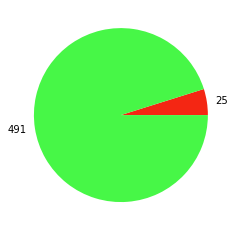

In [13]:
pyplot.pie([outputLog['errors'], outputLog['total']], labels=[outputLog['errors'], outputLog['total']], colors=['#f42613', '#47f747'])